In [1]:
!pip3 install box2d-py

In [2]:
import numpy as np
import torch.nn.functional as F
from collections import deque, namedtuple
from collections import namedtuple
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm import trange
from torch import nn
import torch

In [3]:
class Agent(object):
    ''' Base agent class, used as a parent class

        Args:
            n_actions (int): number of actions

        Attributes:
            n_actions (int): where we store the number of actions
            last_action (int): last action taken by the agent
    '''
    def __init__(self, n_actions: int):
        self.n_actions = n_actions
        self.last_action = None

    def forward(self, state: np.ndarray):
        ''' Performs a forward computation '''
        pass

    def backward(self):
        ''' Performs a backward pass on the network '''
        pass


class RandomAgent(Agent):
    ''' Agent taking actions uniformly at random, child of the class Agent'''
    def __init__(self, n_actions: int):
        super(RandomAgent, self).__init__(n_actions)

    def forward(self, state: np.ndarray) -> int:
        ''' Compute an action uniformly at random across n_actions possible
            choices

            Returns:
                action (int): the random action
        '''
        self.last_action = np.random.randint(0, self.n_actions)
        return self.last_action


In [4]:
class ExperienceReplayBuffer(object):
    """ Class used to store a buffer containing experiences of the RL agent.
    """
    def __init__(self, maximum_length):
        # Create buffer of maximum length
        self.buffer = deque(maxlen=maximum_length)

    def append(self, experience):
        # Append experience to the buffer
        self.buffer.append(experience)

    def __len__(self):
        # overload len operator
        return len(self.buffer)

    def sample_batch(self, n):
        """ Function used to sample experiences from the buffer.
            returns 5 lists, each of size n. Returns a list of state, actions,
            rewards, next states and done variables.
        """
        # If we try to sample more elements that what are available from the
        # buffer we raise an error
        if n > len(self.buffer):
            raise IndexError('Tried to sample too many elements from the buffer!')

        # Sample without replacement the indices of the experiences
        # np.random.choice takes 3 parameters: number of elements of the buffer,
        # number of elements to sample and replacement.
        indices = np.random.choice(
            len(self.buffer),
            size=n,
            replace=False
        )

        # Using the indices that we just sampled build a list of chosen experiences
        batch = [self.buffer[i] for i in indices]

        # batch is a list of size n, where each element is an Experience tuple
        # of 5 elements. To convert a list of tuples into
        # a tuple of list we do zip(*batch). In this case this will return a
        # tuple of 5 elements where each element is a list of n elements.
        return zip(*batch)

In [5]:
class MyNetwork(nn.Module):
    """ Create a feedforward neural network 

        Initialising weights: https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear
    """
    def __init__(self, input_size, output_size, device):
        super(MyNetwork, self).__init__()

        self.device = device

        # Create input layer with ReLU activation
        self.input_layer = nn.Linear(input_size, 8)
        self.input_layer_activation = nn.ReLU()

        self.hidden1 = nn.Linear(8, 64)
        #self.hidden2 = nn.Linear(64,64)

        # Create output layer
        self.output_layer = nn.Linear(64, output_size)

    def forward(self, x):
        # Function used to compute the forward pass

        # Compute first layer
        x = self.input_layer(x)
        x = self.input_layer_activation(x)

        x = F.relu(self.hidden1(x))
        #x = F.relu(self.hidden2(x))
        # Compute output layer
        out = self.output_layer(x)
        return out.to(self.device)

In [6]:
def running_average(x, N):
    ''' Function used to compute the running average
        of the last N elements of a vector x
    '''
    if len(x) >= N:
        y = np.copy(x)
        y[N-1:] = np.convolve(x, np.ones((N, )) / N, mode='valid')
    else:
        y = np.zeros_like(x)
    return y

# Import and initialize the discrete Lunar Laner Environment
env = gym.make('LunarLander-v2')
env.reset()

# Parameters
#N_episodes = 600                             # Number of episodes
#discount_factor = 0.95                       # Value of the discount factor
#n_ep_running_average = 50                    # Running average of 50 episodes
n_actions = env.action_space.n               # Number of available actions
dim_state = len(env.observation_space.low)   # State dimensionality
#batch_size = 32
#buffer_length = 16384                        # Max length of Experience Replay Buffer
#update_freq = 256
#learning_rate = 10e-4
#epsilon_max = 0.99
#epsilon_min = 0.05
#reward_threshold = 100

print('n_actions: ', n_actions)
print('dim_state: ', dim_state)


n_actions:  4
dim_state:  8


In [7]:
def run_DQN_lander(N_episodes=900, 
                    discount_factor=0.99, 
                    n_ep_running_average=50, 
                    n_actions=n_actions,
                    dim_state=dim_state,
                    batch_size=64,
                    buffer_length=16834,
                    update_freq=256,
                    learning_rate=10e-4,
                    epsilon_max=0.99,
                    epsilon_min=0.05,
                    reward_threshold=100,
                    parameter_changed='PutParameterAndValueHere'):
    # We will use these variables to compute the average episodic reward and
    # the average number of steps per episode
    episode_reward_list = []       # this list contains the total reward per episode
    episode_number_of_steps = []   # this list contains the number of steps per episode
    
    # Random agent initialization
    random_agent = RandomAgent(n_actions)
    
    # Experience and experience buffer initialization
    Experience = namedtuple('Experience',
                            ['state', 'action', 'reward', 'next_state', 'done'])
    
    buffer = ExperienceReplayBuffer(buffer_length)
    
    # Reset enviroment data and initialize variables
    state = env.reset()
    for i in range(buffer_length):
        # Take a random action
        action = random_agent.forward(state)
        # Get next state and reward.  The done variable
        # will be True if you reached the goal position,
        # False otherwise
        next_state, reward, done, _ = env.step(action)
        #print("reward: ", reward)
        # Put experience in buffer
        exp = Experience(state, action, reward, next_state, done)
        buffer.append(exp)
    
        if done:
            state = env.reset()
        else:
            state = next_state
    
        # Update state for next iteration
        #state = next_state
    
    ### Training process
    
    # trange is an alternative to range in python, from the tqdm library
    # It shows a nice progression bar that you can update with useful information
    EPISODES = trange(N_episodes, desc='Episode: ', leave=True)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    #device = torch.device("cpu")
    
    # TO DO: CHECK IF STATE SPACE IS CORRECTLY DEFINED
    target_network = MyNetwork(input_size = dim_state, output_size = n_actions, device=device).to(device)
    network = MyNetwork(input_size = dim_state, output_size = n_actions, device=device).to(device)
    
    target_network.eval()
    network.train()
    
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    
    for i in EPISODES:
        # Reset enviroment data and initialize variables
        done = False
        state = env.reset()
        total_episode_reward = 0.
        t = 0
    
        # Define epsilon
        epsilon = np.max([epsilon_min, epsilon_max-(epsilon_max - epsilon_min)*(i-1)/(N_episodes*0.9-1)])
    
        while not done:
    
            target_network.eval()
            network.train()
    
            #if i >= N_episodes-20:
            #    env.render()
    
            # Put state in a tensor for the NN
            state_tensor = torch.tensor([state],
                                        requires_grad=False,
                                        dtype=torch.float32).to(device)
    
            # Take epsilon greedy action
            if torch.rand((1,)) < epsilon:
                action = env.action_space.sample()
            else:
                values = network(state_tensor)
                action = values.max(1)[1].item()
    
            # Get next state and reward.  The done variable
            # will be True if you reached the goal position,
            # False otherwise
            next_state, reward, done, _ = env.step(action)
    
            # Append experience to Buffer
            exp = Experience(state, action, reward, next_state, done)
            buffer.append(exp)
    
            # Update episode reward
            total_episode_reward += reward
    
            # Sample experiences from the buffer 
            states, actions, rewards, next_states, dones = buffer.sample_batch(batch_size)
    
            # Training process, set gradients to 0
            optimizer.zero_grad()
    
            NN_outputs = network(torch.tensor(states,
                                            requires_grad=True,
                                            dtype=torch.float32).to(device))
    
            NN_outputs = NN_outputs[torch.arange(batch_size), torch.tensor(actions).to(device)]
    
            # Compute output of the network given the states batch
            target_NN_outputs = target_network(torch.tensor(next_states,
                                                requires_grad=False,
                                                dtype=torch.float32).to(device)).detach()
    
            # y = reward +  discount_factor* (1 - dones) * target_q_values.
            target_NN_outputs = torch.tensor(rewards, dtype=torch.float32).to(device) + ~torch.tensor(dones).to(device) * (discount_factor * target_NN_outputs.max(1).values)
    
            # Compute loss function
            loss = nn.functional.mse_loss(
                            target_NN_outputs,
                            NN_outputs)
    
            # Compute gradient
            loss.backward()
    
            # Clip gradient norm to 1
            nn.utils.clip_grad_norm_(network.parameters(), max_norm=1.)
    
            # Perform backward pass (backpropagation)
            optimizer.step()
    
            if t % update_freq == 0:
                target_network.load_state_dict(network.state_dict())
    
            # Update state for next iteration
            state = next_state
            t += 1
    
        # Append episode reward and total number of steps
        episode_reward_list.append(total_episode_reward)
        episode_number_of_steps.append(t)
    
        # Close environment
        env.close()
    
        if running_average(episode_reward_list, n_ep_running_average)[-1] > reward_threshold:
            #torch.save(target_network.cpu(), 'neural-network-1_{}.pth'.format(parameter_changed))
            break
    
        # Updates the tqdm update bar with fresh information
        # (episode number, total reward of the last episode, total number of Steps
        # of the last episode, average reward, average number of steps)
        EPISODES.set_description(
            "Episode {} - Reward/Steps: {:.1f}/{} - Avg. Reward/Steps: {:.1f}/{}".format(
            i, total_episode_reward, t,
            running_average(episode_reward_list, n_ep_running_average)[-1],
            running_average(episode_number_of_steps, n_ep_running_average)[-1]))
    
    #torch.save(target_network.cpu(), 'neural-network-1.pth')
    
    # Plot Rewards and steps
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 9))
    ax[0].plot([k for k in range(1, i+2)], episode_reward_list, label='Episode reward')
    ax[0].plot([k for k in range(1, i+2)], running_average(
        episode_reward_list, n_ep_running_average), label='Avg. episode reward')
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Total reward')
    ax[0].set_title('Total Reward vs Episodes')
    ax[0].legend()
    ax[0].grid(alpha=0.3)
    
    ax[1].plot([k for k in range(1, i+2)], episode_number_of_steps, label='Steps per episode')
    ax[1].plot([k for k in range(1, i+2)], running_average(
        episode_number_of_steps, n_ep_running_average), label='Avg. number of steps per episode')
    ax[1].set_xlabel('Episodes')
    ax[1].set_ylabel('Total number of steps')
    ax[1].set_title('Total number of steps vs Episodes')
    ax[1].legend()
    ax[1].grid(alpha=0.3)
    plt.show()
    plt.savefig('reward_steps_plot_{}.png'.format(parameter_changed))
    plt.clf()

Episode 834 - Reward/Steps: 8.0/187 - Avg. Reward/Steps: 99.4/418:  93%|█████████▎| 835/900 [20:58<02:11,  2.03s/it]

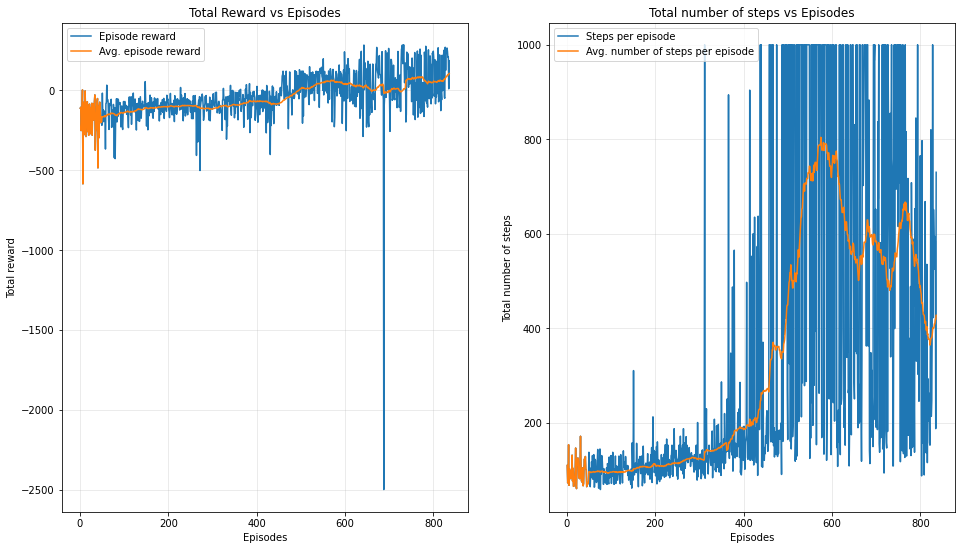

<Figure size 432x288 with 0 Axes>

In [8]:
run_DQN_lander()


Episode:   0%|          | 0/900 [00:00<?, ?it/s]
Episode 0 - Reward/Steps: -87.6/62 - Avg. Reward/Steps: 0.0/0:   0%|          | 0/900 [00:00<?, ?it/s]
Episode 0 - Reward/Steps: -87.6/62 - Avg. Reward/Steps: 0.0/0:   0%|          | 1/900 [00:00<02:53,  5.18it/s]
Episode 1 - Reward/Steps: -464.3/98 - Avg. Reward/Steps: 0.0/0:   0%|          | 1/900 [00:00<02:53,  5.18it/s]
Episode 1 - Reward/Steps: -464.3/98 - Avg. Reward/Steps: 0.0/0:   0%|          | 2/900 [00:00<03:28,  4.30it/s]
Episode 2 - Reward/Steps: -142.0/99 - Avg. Reward/Steps: 0.0/0:   0%|          | 2/900 [00:00<03:28,  4.30it/s]
Episode 2 - Reward/Steps: -142.0/99 - Avg. Reward/Steps: 0.0/0:   0%|          | 3/900 [00:00<03:56,  3.80it/s]
Episode 3 - Reward/Steps: -351.2/89 - Avg. Reward/Steps: 0.0/0:   0%|          | 3/900 [00:01<03:56,  3.80it/s]
Episode 3 - Reward/Steps: -351.2/89 - Avg. Reward/Steps: 0.0/0:   0%|          | 4/900 [00:01<04:06,  3.64it/s]
Episode 4 - Reward/Steps: -317.6/89 - Avg. Reward/Steps: 0.0/0: 

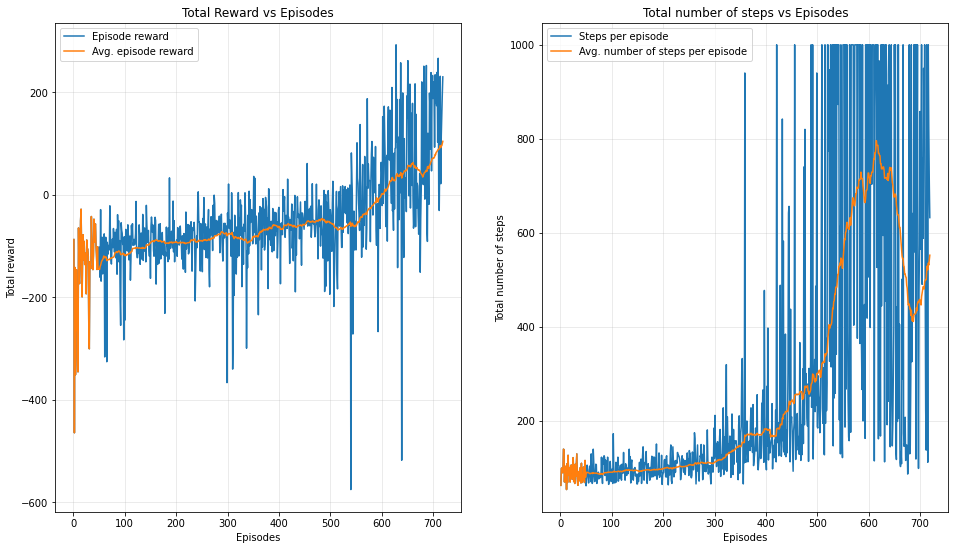



Episode:   0%|          | 0/900 [00:00<?, ?it/s]

Episode 0 - Reward/Steps: -386.3/91 - Avg. Reward/Steps: 0.0/0:   0%|          | 0/900 [00:00<?, ?it/s]

Episode 0 - Reward/Steps: -386.3/91 - Avg. Reward/Steps: 0.0/0:   0%|          | 1/900 [00:00<05:32,  2.70it/s]

Episode 1 - Reward/Steps: -216.6/103 - Avg. Reward/Steps: 0.0/0:   0%|          | 1/900 [00:00<05:32,  2.70it/s]

Episode 1 - Reward/Steps: -216.6/103 - Avg. Reward/Steps: 0.0/0:   0%|          | 2/900 [00:00<05:50,  2.56it/s]

Episode 2 - Reward/Steps: -56.8/69 - Avg. Reward/Steps: 0.0/0:   0%|          | 2/900 [00:01<05:50,  2.56it/s]  

Episode 2 - Reward/Steps: -56.8/69 - Avg. Reward/Steps: 0.0/0:   0%|          | 3/900 [00:01<05:26,  2.74it/s]

Episode 3 - Reward/Steps: -240.8/72 - Avg. Reward/Steps: 0.0/0:   0%|          | 3/900 [00:01<05:26,  2.74it/s]

Episode 3 - Reward/Steps: -240.8/72 - Avg. Reward/Steps: 0.0/0:   0%|          | 4/900 [00:01<05:07,  2.91it/s]

Episode 4 - Reward/Steps: -215.7/124 - Avg. Reward

<Figure size 432x288 with 0 Axes>

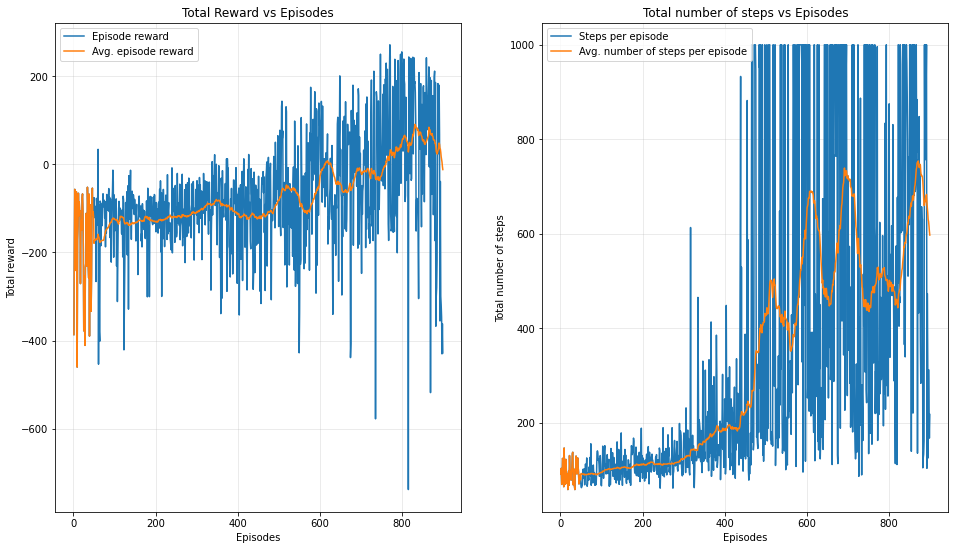

<Figure size 432x288 with 0 Axes>

In [9]:
# Batch size
batch_sizes = [8, 128]
for batch_size in batch_sizes:
    run_DQN_lander(batch_size=batch_size, parameter_changed='batch_size_{}'.format(batch_size))



Episode:   0%|          | 0/300 [00:00<?, ?it/s]

Episode 0 - Reward/Steps: -70.3/69 - Avg. Reward/Steps: 0.0/0:   0%|          | 0/300 [00:00<?, ?it/s]

Episode 0 - Reward/Steps: -70.3/69 - Avg. Reward/Steps: 0.0/0:   0%|          | 1/300 [00:00<01:26,  3.46it/s]

Episode 1 - Reward/Steps: -303.5/91 - Avg. Reward/Steps: 0.0/0:   0%|          | 1/300 [00:00<01:26,  3.46it/s]

Episode 1 - Reward/Steps: -303.5/91 - Avg. Reward/Steps: 0.0/0:   1%|          | 2/300 [00:00<01:31,  3.27it/s]

Episode 2 - Reward/Steps: -84.0/66 - Avg. Reward/Steps: 0.0/0:   1%|          | 2/300 [00:00<01:31,  3.27it/s] 

Episode 2 - Reward/Steps: -84.0/66 - Avg. Reward/Steps: 0.0/0:   1%|          | 3/300 [00:00<01:26,  3.45it/s]

Episode 3 - Reward/Steps: -64.8/70 - Avg. Reward/Steps: 0.0/0:   1%|          | 3/300 [00:01<01:26,  3.45it/s]

Episode 3 - Reward/Steps: -64.8/70 - Avg. Reward/Steps: 0.0/0:   1%|▏         | 4/300 [00:01<01:24,  3.49it/s]

Episode 4 - Reward/Steps: -106.1/64 - Avg. Reward/Steps: 

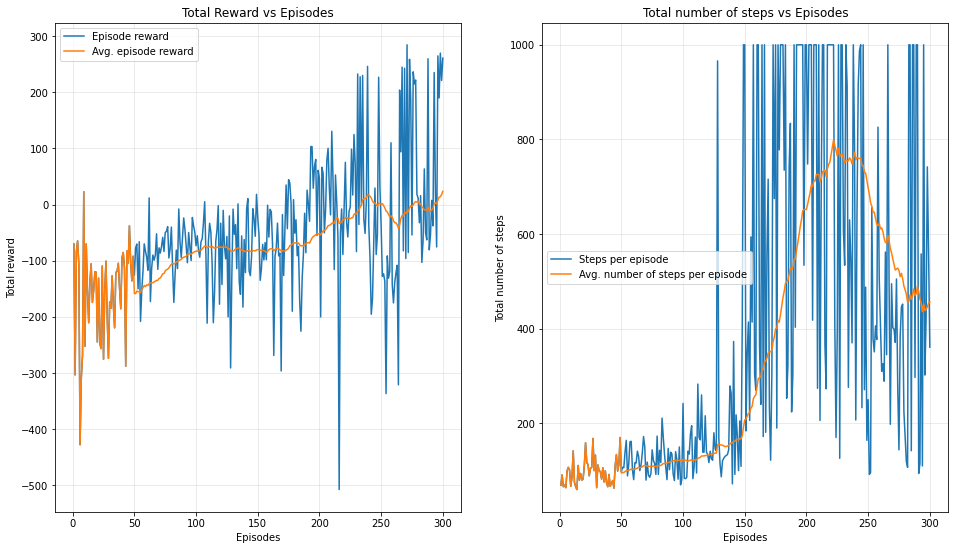



Episode:   0%|          | 0/600 [00:00<?, ?it/s]

Episode 0 - Reward/Steps: -281.1/93 - Avg. Reward/Steps: 0.0/0:   0%|          | 0/600 [00:00<?, ?it/s]

Episode 0 - Reward/Steps: -281.1/93 - Avg. Reward/Steps: 0.0/0:   0%|          | 1/600 [00:00<03:24,  2.93it/s]

Episode 1 - Reward/Steps: -79.8/76 - Avg. Reward/Steps: 0.0/0:   0%|          | 1/600 [00:00<03:24,  2.93it/s] 

Episode 1 - Reward/Steps: -79.8/76 - Avg. Reward/Steps: 0.0/0:   0%|          | 2/600 [00:00<03:21,  2.98it/s]

Episode 2 - Reward/Steps: -124.5/78 - Avg. Reward/Steps: 0.0/0:   0%|          | 2/600 [00:00<03:21,  2.98it/s]

Episode 2 - Reward/Steps: -124.5/78 - Avg. Reward/Steps: 0.0/0:   0%|          | 3/600 [00:00<03:13,  3.09it/s]

Episode 3 - Reward/Steps: -327.1/120 - Avg. Reward/Steps: 0.0/0:   0%|          | 3/600 [00:01<03:13,  3.09it/s]

Episode 3 - Reward/Steps: -327.1/120 - Avg. Reward/Steps: 0.0/0:   1%|          | 4/600 [00:01<03:35,  2.77it/s]

Episode 4 - Reward/Steps: -80.4/73 - Avg. Reward/St

<Figure size 432x288 with 0 Axes>

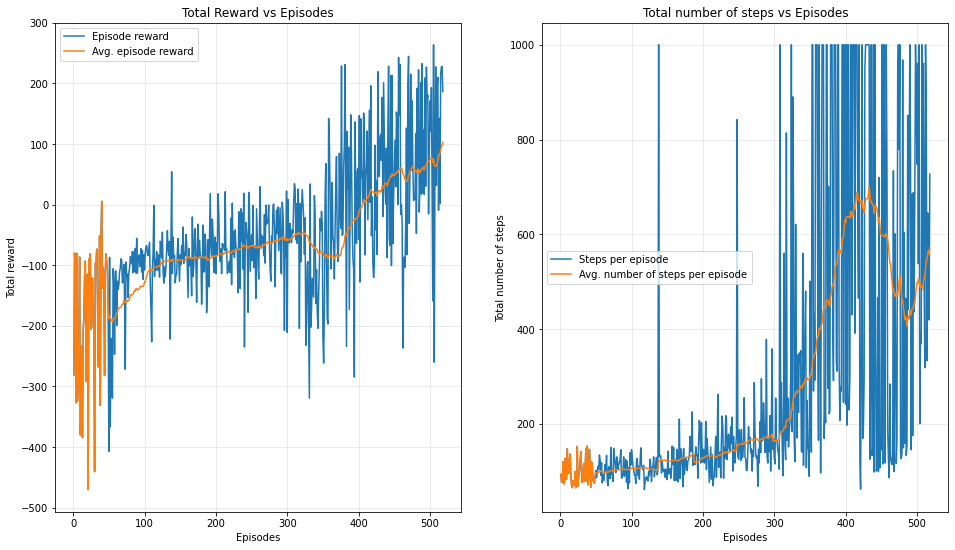

<Figure size 432x288 with 0 Axes>

In [10]:
# Number of episodes
episodes_values = [300, 600]
for n_episodes in episodes_values:
    run_DQN_lander(N_episodes=n_episodes, parameter_changed='n_episodes_{}'.format(n_episodes))

Streaminguitvoer ingekort tot de laatste 5000 regels.

Episode 66 - Reward/Steps: -186.8/65 - Avg. Reward/Steps: -170.7/96:   7%|▋         | 67/900 [00:25<05:15,  2.64it/s]


Episode 67 - Reward/Steps: -355.0/123 - Avg. Reward/Steps: -170.5/96:   7%|▋         | 67/900 [00:25<05:15,  2.64it/s]


Episode 67 - Reward/Steps: -355.0/123 - Avg. Reward/Steps: -170.5/96:   8%|▊         | 68/900 [00:25<05:34,  2.49it/s]


Episode 68 - Reward/Steps: -340.2/101 - Avg. Reward/Steps: -175.2/97:   8%|▊         | 68/900 [00:25<05:34,  2.49it/s]


Episode 68 - Reward/Steps: -340.2/101 - Avg. Reward/Steps: -175.2/97:   8%|▊         | 69/900 [00:25<05:29,  2.52it/s]


Episode 69 - Reward/Steps: -71.1/75 - Avg. Reward/Steps: -169.6/96:   8%|▊         | 69/900 [00:26<05:29,  2.52it/s]  


Episode 69 - Reward/Steps: -71.1/75 - Avg. Reward/Steps: -169.6/96:   8%|▊         | 70/900 [00:26<05:03,  2.73it/s]


Episode 70 - Reward/Steps: -243.1/112 - Avg. Reward/Steps: -170.8/96:   8%|▊         | 70/900 [00:26<

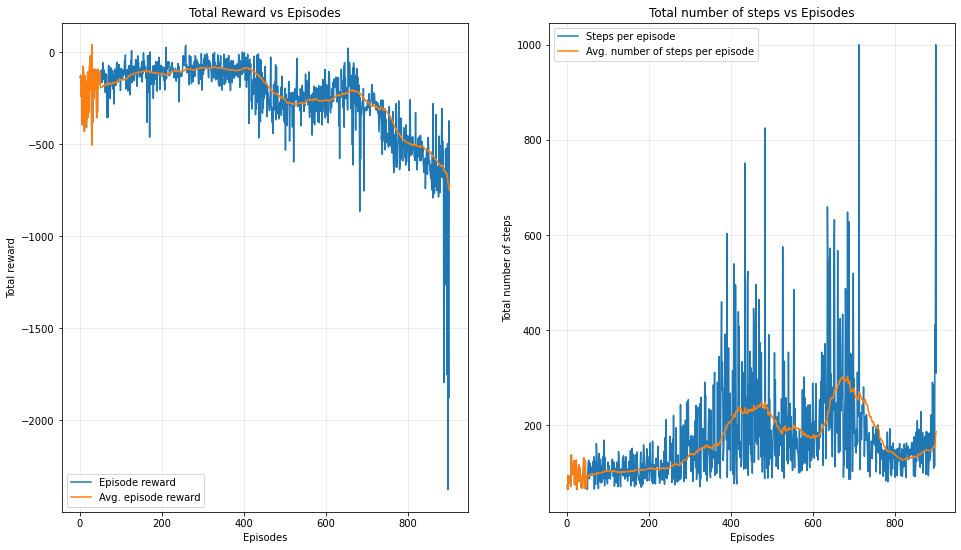

Streaminguitvoer ingekort tot de laatste 5000 regels.

Episode 66 - Reward/Steps: -133.5/80 - Avg. Reward/Steps: -166.4/99:   7%|▋         | 67/900 [00:25<05:25,  2.56it/s]


Episode 67 - Reward/Steps: -156.9/110 - Avg. Reward/Steps: -162.9/99:   7%|▋         | 67/900 [00:26<05:25,  2.56it/s]


Episode 67 - Reward/Steps: -156.9/110 - Avg. Reward/Steps: -162.9/99:   8%|▊         | 68/900 [00:26<05:32,  2.51it/s]


Episode 68 - Reward/Steps: -286.0/82 - Avg. Reward/Steps: -166.3/99:   8%|▊         | 68/900 [00:26<05:32,  2.51it/s] 


Episode 68 - Reward/Steps: -286.0/82 - Avg. Reward/Steps: -166.3/99:   8%|▊         | 69/900 [00:26<05:11,  2.67it/s]


Episode 69 - Reward/Steps: -68.5/60 - Avg. Reward/Steps: -162.0/98:   8%|▊         | 69/900 [00:26<05:11,  2.67it/s] 


Episode 69 - Reward/Steps: -68.5/60 - Avg. Reward/Steps: -162.0/98:   8%|▊         | 70/900 [00:26<04:35,  3.01it/s]


Episode 70 - Reward/Steps: -110.6/127 - Avg. Reward/Steps: -160.9/99:   8%|▊         | 70/900 [00:27<04

<Figure size 432x288 with 0 Axes>

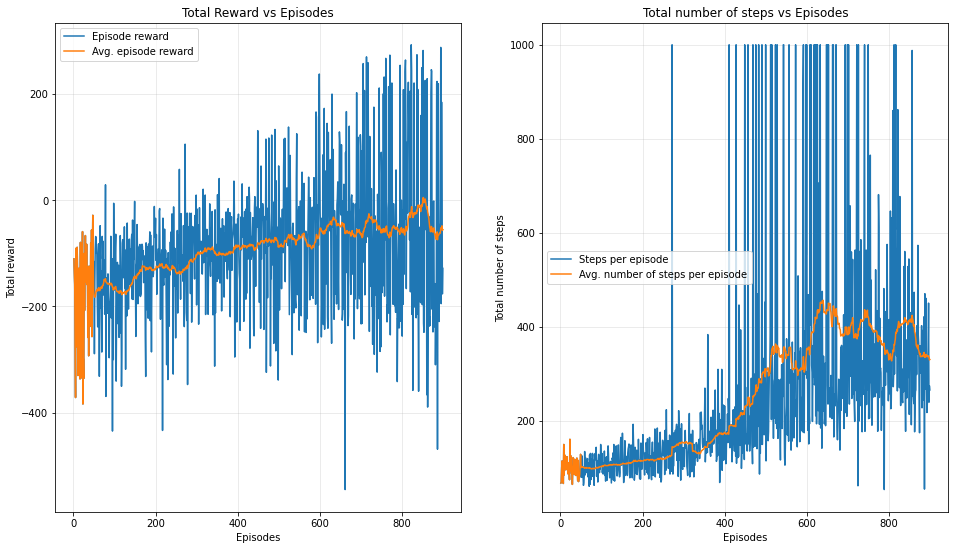

<Figure size 432x288 with 0 Axes>

In [11]:
# Discount factor
discount_values = [1, 0.5]
for discount_factor in discount_values:
    run_DQN_lander(discount_factor=discount_factor, parameter_changed='discount_factor_{}'.format(discount_factor))